In [141]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (balanced_accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             matthews_corrcoef, log_loss, roc_curve, auc)
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from torch_geometric.loader import DataLoader
from causallearn.search.FCMBased import lingam
import networkx as nx
import itertools

In [143]:
torch.manual_seed(42)
np.random.seed(42)

data_path = 'Documents/tennessee-eastmen-process-classification/TE_process/data/'

def load_data(file_path):
    data = pd.read_csv(file_path, sep=r'\s+', header=None)
    return data.values

def create_dataset():
    X = []
    y = []
    
    for i in range(22):
        train_file = os.path.join(data_path, f'd{i:02d}.dat')
        train_data = load_data(train_file)
        X.append(train_data)
        y.append(np.full(train_data.shape[0], 1 if i > 0 else 0))
        
        test_file = os.path.join(data_path, f'd{i:02d}_te.dat')
        test_data = load_data(test_file)
        X.append(test_data)
        if i == 0:
            y.append(np.zeros(test_data.shape[0]))
        else:
            y.append(np.concatenate([np.zeros(160), np.ones(test_data.shape[0] - 160)]))
    
    X = np.vstack(X)
    y = np.concatenate(y)
    
    return X, y

In [145]:
def create_dag(X, y, threshold=abs(5)):
    data_with_output = np.column_stack((X, y))
    
    model = lingam.ICALiNGAM()
    model.fit(data_with_output)
    
    G = nx.DiGraph()
    n_features = X.shape[1]
    for i in range(n_features + 1):
        for j in range(n_features + 1):
            if abs(model.adjacency_matrix_[i, j]) > threshold:
                G.add_edge(i, j, weight=model.adjacency_matrix_[i, j])
    
    return G, model.adjacency_matrix_

def adjacency_matrix_to_edge_index(adj_matrix):
    edge_index = []
    edge_attr = []
    rows, cols = np.where(adj_matrix != 0)
    for row, col in zip(rows, cols):
        edge_index.append([row, col])
        edge_attr.append([adj_matrix[row, col], 0])  
        edge_index.append([col, row])
        edge_attr.append([0, adj_matrix[row, col]])  
    
    return (torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            torch.tensor(edge_attr, dtype=torch.float))

def plot_dag(G, num_features, save_path=None):
    plt.figure(figsize=(20, 15))
    
    actual_nodes = list(G.nodes())
    feature_nodes = [node for node in actual_nodes if node < num_features]
    output_node = max(actual_nodes) if actual_nodes else num_features  
    
    pos = nx.spring_layout(G, k=0.9, iterations=50)
    
    feature_nodes_circles = nx.draw_networkx_nodes(G, pos, nodelist=feature_nodes, node_color='white', 
                                                   edgecolors='black', node_size=3000, alpha=0.8)
    output_node_circle = nx.draw_networkx_nodes(G, pos, nodelist=[output_node], node_color='lightgray', 
                                                edgecolors='black', node_size=4000, alpha=0.8)
    
    node_labels = {i: f"X{i+1}" for i in feature_nodes}
    node_labels[output_node] = 'Fault'
    nx.draw_networkx_labels(G, pos, node_labels, font_size=10, font_weight='bold')
    
    def get_connection_points(start_pos, end_pos, radius):
        angle = np.arctan2(end_pos[1] - start_pos[1], end_pos[0] - start_pos[0])
        start_point = (start_pos[0] + radius * np.cos(angle),
                       start_pos[1] + radius * np.sin(angle))
        end_point = (end_pos[0] - radius * np.cos(angle),
                     end_pos[1] - radius * np.sin(angle))
        return start_point, end_point
    
    edge_weights = []
    for edge in G.edges(data=True):
        start_node, end_node, data = edge
        weight = abs(data['weight'])
        edge_weights.append(weight)
        
        start_pos, end_pos = pos[start_node], pos[end_node]
        
        start_radius = 0.04 if start_node != output_node else 0.05
        end_radius = 0.04 if end_node != output_node else 0.05
        
        start_point, end_point = get_connection_points(start_pos, end_pos, start_radius)
        
        arrow = ConnectionPatch(start_point, end_point, 'data', 'data', arrowstyle='->', 
                                mutation_scale=20, lw=1.5, alpha=0.7, color='gray',
                                connectionstyle='arc3,rad=0.1')
        plt.gca().add_patch(arrow)
        
        middle_point = ((start_point[0] + end_point[0])/2, (start_point[1] + end_point[1])/2)
        plt.text(middle_point[0], middle_point[1], f'{weight:.3f}', 
                 fontsize=8, ha='center', va='center', 
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    if edge_weights:
        max_weight = max(edge_weights)
        normalized_weights = [w/max_weight for w in edge_weights]
        
        nx.draw_networkx_edges(G, pos, width=normalized_weights, edge_color='gray', arrows=True, 
                               arrowsize=20, connectionstyle='arc3,rad=0.1')
    
    plt.title("Causal DAG for Tennessee Eastman Process", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Total nodes: {G.number_of_nodes()}")
    print(f"Total edges: {G.number_of_edges()}")
    if edge_weights:
        print(f"Minimum edge weight: {min(edge_weights):.3f}")
        print(f"Maximum edge weight: {max(edge_weights):.3f}")
    else:
        print("No edges in the graph.")

In [147]:
def create_directed_edge_index(G, num_nodes):
    edge_index = []
    edge_attr = []
    for edge in G.edges():
        edge_index.append([edge[0], edge[1]])
        edge_attr.append([1, 0])  
        edge_index.append([edge[1], edge[0]])
        edge_attr.append([0, 1]) 
    return (torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
            torch.tensor(edge_attr, dtype=torch.float))

class CausalGNN(nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(CausalGNN, self).__init__()
        self.conv1 = GATv2Conv(num_features, hidden_channels, edge_dim=2)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels // 2, edge_dim=2)
        self.fc = nn.Linear(hidden_channels // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = self.relu(x)
        x = self.fc(x)
        return torch.sigmoid(x)

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr).squeeze()
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    out_probs = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr).squeeze()
            out_probs.extend(out.cpu().numpy())
            targets.extend(data.y.cpu().numpy())
    
    fpr, tpr, thresholds = roc_curve(targets, out_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    predictions = (np.array(out_probs) > optimal_threshold).astype(int)
    
    return (balanced_accuracy_score(targets, predictions), 
            precision_score(targets, predictions), 
            recall_score(targets, predictions), 
            f1_score(targets, predictions),
            matthews_corrcoef(targets, predictions), 
            roc_auc_score(targets, out_probs),
            log_loss(targets, out_probs), 
            predictions, targets, optimal_threshold)

In [149]:
def plot_training_history(train_scores, test_scores, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_scores, label='Train')
    plt.plot(test_scores, label='Test')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Normal', 'Fault'])
    plt.yticks(tick_marks, ['Normal', 'Fault'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [151]:
def main():
    print("Loading and preprocessing data...")
    X, y = create_dataset()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)  
    
    print("Performing causal discovery using LiNGAM algorithm...")
    threshold = abs(5)
    G, adjacency_matrix = create_dag(X_train_scaled, y_train_resampled, threshold)
    plot_dag(G, X_train_scaled.shape[1], save_path='causal_dag.png')
    
    print("Edges in the causal graph:")
    for edge in G.edges():
        print(f"X{edge[0]+1} --> X{edge[1]+1}" if edge[1] < X_train_scaled.shape[1] else f"X{edge[0]+1} --> Fault")
    
    edge_index, edge_attr = adjacency_matrix_to_edge_index(adjacency_matrix)
    
    train_data = Data(x=torch.tensor(X_train_scaled, dtype=torch.float32),
                      edge_index=edge_index,
                      edge_attr=edge_attr,
                      y=torch.tensor(y_train_resampled, dtype=torch.float32))
    test_data = Data(x=torch.tensor(X_test_scaled, dtype=torch.float32),
                     edge_index=edge_index,
                     edge_attr=edge_attr,
                     y=torch.tensor(y_test, dtype=torch.float32))
    
    train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CausalGNN(num_features=X_train_scaled.shape[1], hidden_channels=128).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    num_epochs = 500
    patience = 70
    best_auc = 0
    counter = 0
    train_auc_scores = []
    test_auc_scores = []
    
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        _, _, _, _, _, train_auc, _, _, _, _ = evaluate_model(model, train_loader, device)
        test_bal_acc, test_prec, test_rec, test_f1, test_mcc, test_auc, test_logloss, test_preds, test_targets, threshold = evaluate_model(model, test_loader, device)
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}')
        
        train_auc_scores.append(train_auc)
        test_auc_scores.append(test_auc)
        
        if test_auc > best_auc:
            best_auc = test_auc
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            best_threshold = threshold
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    model.load_state_dict(torch.load('best_model.pth'))
    
    test_bal_acc, test_prec, test_rec, test_f1, test_mcc, test_auc, test_logloss, test_preds, test_targets, _ = evaluate_model(model, test_loader, device)
    print(f"Final Test Results: Balanced Accuracy: {test_bal_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}, AUC: {test_auc:.4f}, Log Loss: {test_logloss:.4f}")
    
    plot_training_history(train_auc_scores, test_auc_scores, "Training and Test AUC Scores Over Epochs")
    plot_confusion_matrix(test_targets, test_preds)
    plot_roc_curve(test_targets, test_preds)

Loading and preprocessing data...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74f1dddf7920>
Traceback (most recent call last):
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/tuso/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 's

Performing causal discovery using LiNGAM algorithm...


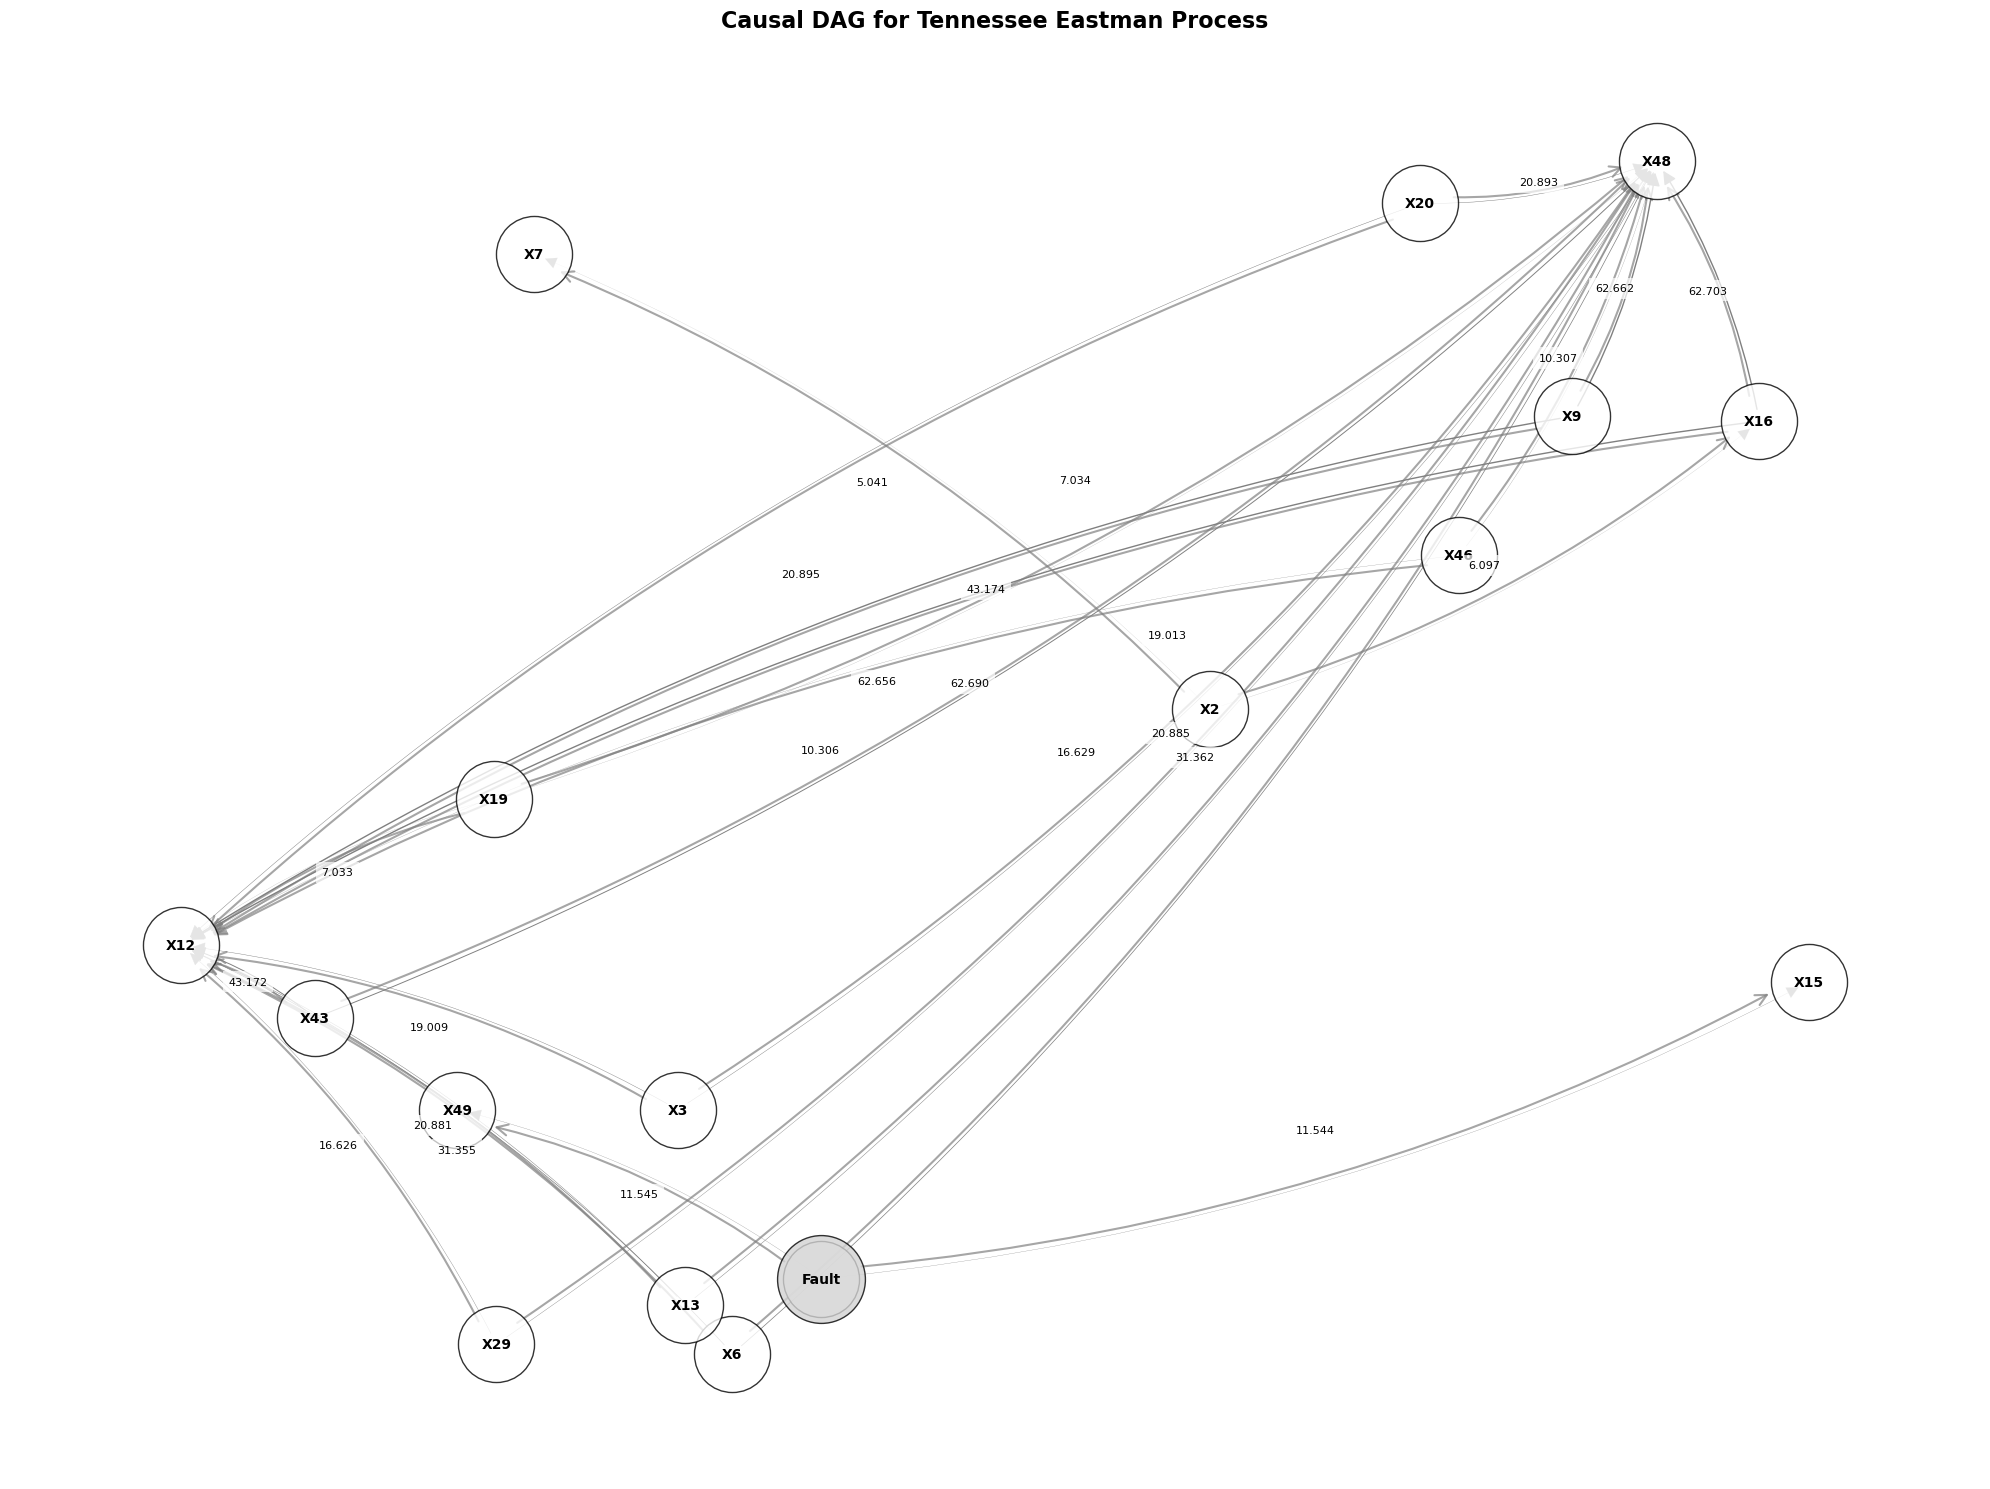

Total nodes: 17
Total edges: 24
Minimum edge weight: 5.041
Maximum edge weight: 62.703
Edges in the causal graph:
X2 --> X7
X2 --> X16
X16 --> X12
X16 --> X48
X3 --> X12
X3 --> X48
X6 --> X12
X6 --> X48
X9 --> X12
X9 --> X48
X13 --> X12
X13 --> X48
X19 --> X12
X19 --> X48
X20 --> X12
X20 --> X48
X29 --> X12
X29 --> X48
X43 --> X12
X43 --> X48
X46 --> X12
X46 --> X48
X52 --> X15
X52 --> X49
Epoch 1/500: Train AUC: 0.5468, Test AUC: 0.5209
Epoch 2/500: Train AUC: 0.6051, Test AUC: 0.5723
Epoch 3/500: Train AUC: 0.6578, Test AUC: 0.6234
Epoch 4/500: Train AUC: 0.6910, Test AUC: 0.6581
Epoch 5/500: Train AUC: 0.7045, Test AUC: 0.6711
Epoch 6/500: Train AUC: 0.7133, Test AUC: 0.6795
Epoch 7/500: Train AUC: 0.7190, Test AUC: 0.6849
Epoch 8/500: Train AUC: 0.7226, Test AUC: 0.6888
Epoch 9/500: Train AUC: 0.7245, Test AUC: 0.6915
Epoch 10/500: Train AUC: 0.7253, Test AUC: 0.6932
Epoch 11/500: Train AUC: 0.7252, Test AUC: 0.6941
Epoch 12/500: Train AUC: 0.7246, Test AUC: 0.6946
Epoch 13/500: Tr

/tmp/ipykernel_132258/4190594865.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


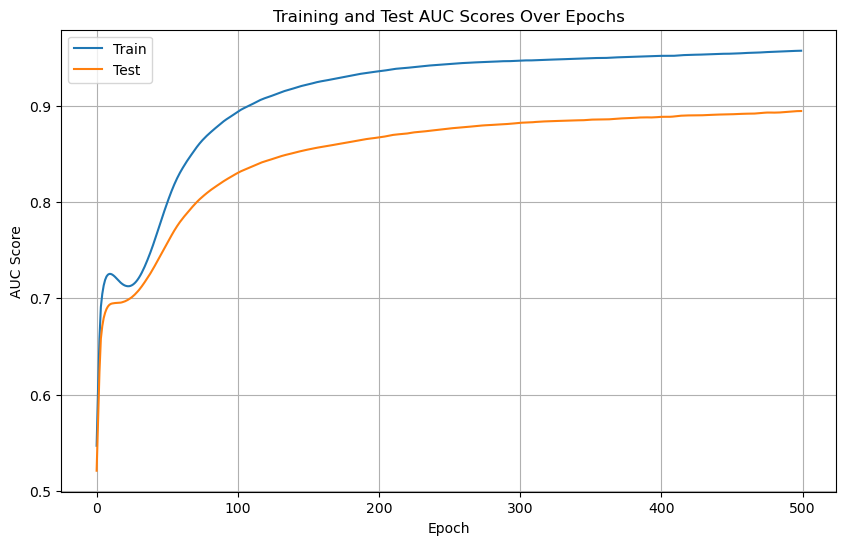

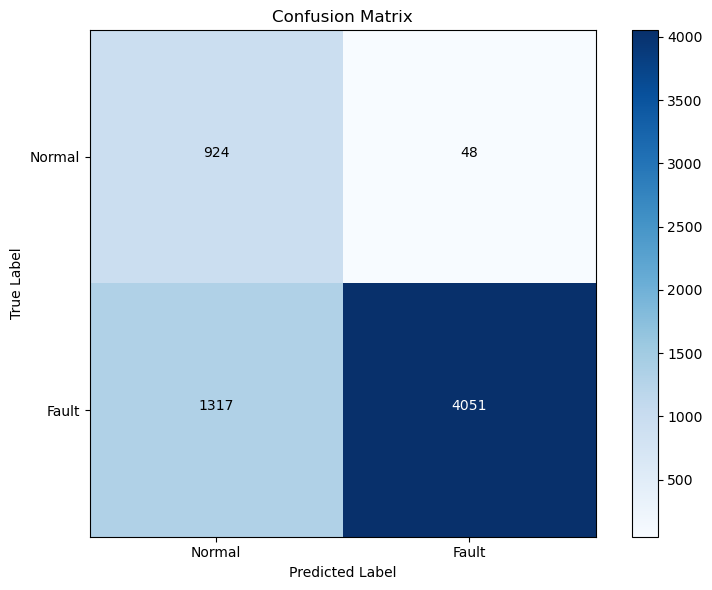

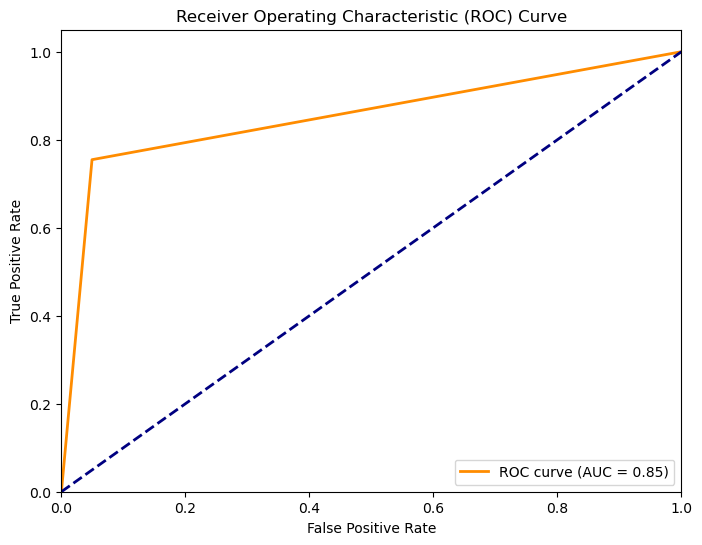

In [153]:
main()